<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/12-rnn-alternatives/03_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transformer

The alternative to RNNs is the transformer architecture. It
is built out of two primary subcomponents: 

1. positional encoding 
2. multiheaded attention

The original attention mechanism has one context, which allows it to look for one kind of pattern.

But what if you want to look for multiple different things at once (like a positive statement “good” preceded by a negation statement “not”)?

This is where multiheaded attention
comes into play. Each “head” of the multihead attention can learn to look for different
kinds of patterns, similar to how each filter in a convolutional layer can learn to look for
different patterns.

The analogy, we can think about MHA as a kind of
deep learning alternative to the standard Python dictionary object. A dictionary `d = {'key' : value}` represents a set of keys, each with a specific value. You can then
query that dictionary with something like `d['query']`. If query in `d`, you get its associated
value, but if not you get None. 

An MHA layer has the same overall goals but does
not require perfect matches between queries and keys as a dictionary does. Instead,
it’s a little soft, and multiple similar keys can respond to a single query.

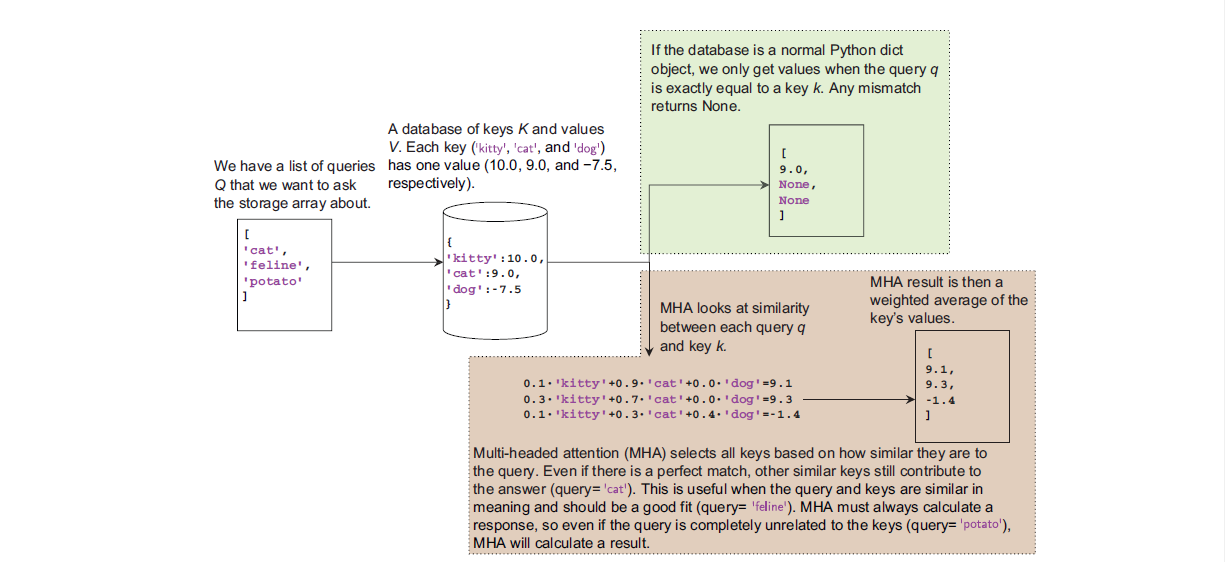

The MHA works the same way: it starts out with randomly initialized and
meaningless keys and values but learns to adjust them to something useful during
training.

##Setup

In [ ]:
!pip install portalocker

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

from torchtext.datasets import AG_NEWS

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import math
import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

from idlmam import set_seed
from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore #For attention mechanism use

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [5]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
import warnings
warnings.filterwarnings("ignore")

##AG News dataset

In [8]:
# let’s quickly load AG_NEWS dataset
train_iter, test_iter = AG_NEWS(root="./data", split=("train", "test"))

train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [9]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [10]:
# tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer("basic_english") # we will be fine with the default english style tokenizer

# we need to create a vocabulary of all the words in the training set
counter = Counter()
for (label, line) in train_dataset:
  # count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
  counter.update(tokenizer(line))
# create a vocab object, removing any word that didn't occur at least 10 times, 
# and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"
vocab = vocab(counter, min_freq=10, specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"))
vocab.set_default_index(vocab["<unk>"])

In [11]:
len(vocab)

20647

In [12]:
def text_transform(x):
  # vocab acts like a dictionary, handls unkown tokens.
  # We can make it pre- and post-pend with the start and end markers, respectively.
  return [vocab["<BOS>"]] + [vocab[token] for token in tokenizer(x)] + [vocab["<EOS>"]]

def label_transform(y):
  # labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3] 
  return y - 1

In [13]:
train_dataset[0][1]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [14]:
# let's transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 0, 17, 4, 18, 19, 20, 0, 21, 0, 17, 22, 23, 24, 25, 6, 2]


In [15]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
VOCAB_SIZE  = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print(f"Vocab: {VOCAB_SIZE}")
print(f"Num Classes: {NUM_CLASS}")

padding_idx = vocab["<PAD>"]
embed_dim = 128
B = 64
epochs = 15

Vocab: 20647
Num Classes: 4


In [16]:
def pad_batch(batch):
  """
  Pad items in the batch to the length of the longest item in the batch. 
  Also, re-order so that the values are returned (input, label)
  """
  # transform every label in the batch
  labels = [label_transform(z[0]) for z in batch]
  # tokenizes every text and puts them into a tensor
  texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch]

  # what is the longest sequence in this batch?
  max_len = max([text.size(0) for text in texts])
  # pad each text tensor by whatever amount gets it to the max_len
  texts = [F.pad(text, (0, max_len - text.size(0)), value=padding_idx) for text in texts]
  # make x and y a single tensor
  x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
  return  x, y

In [17]:
# Now we can build our DataLoaders
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [18]:
iterator = iter(train_loader)

batch1 = next(iterator)

In [19]:
batch1

(tensor([[    1,  7034,  9930,  ...,     3,     3,     3],
         [    1,   721,  1952,  ...,     3,     3,     3],
         [    1,  1814,  1104,  ...,     3,     3,     3],
         ...,
         [    1, 20355,  3099,  ...,     3,     3,     3],
         [    1,    11,   386,  ...,     3,     3,     3],
         [    1,     0,    17,  ...,     3,     3,     3]]),
 tensor([1, 3, 3, 3, 1, 2, 0, 2, 1, 3, 3, 2, 2, 2, 2, 2, 0, 3, 1, 1, 3, 2, 3, 3,
         1, 1, 0, 2, 3, 3, 2, 3, 3, 2, 1, 0, 1, 3, 3, 1, 3, 1, 2, 1, 1, 3, 1, 2,
         3, 0, 1, 3, 1, 3, 1, 3, 0, 2, 3, 0, 1, 1, 3, 0]))

##Baseline model

In [20]:
gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), # (B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), # We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim * 2, NUM_CLASS)    # (B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()

In [ ]:
gru_results = train_network(gru, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

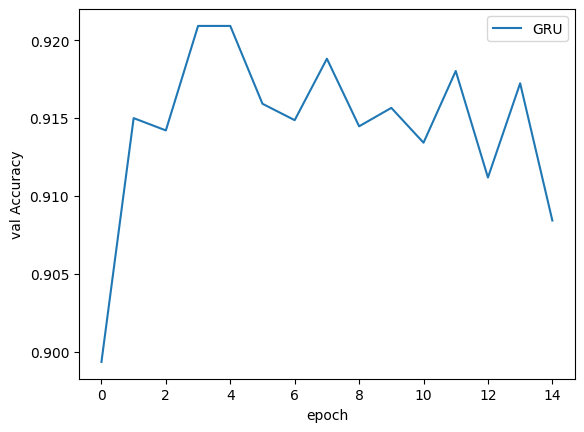

In [22]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="GRU")

##Attention Embedding

In [27]:
class AttentionEmbedding(nn.Module):

  def __init__(self, vocab_size, D, embedding_layers=3, padding_idx=None):
    super(AttentionEmbedding, self).__init__()

    self.padding_idx = padding_idx 
    self.embedding_layer = nn.Embedding(vocab_size, D, padding_idx=padding_idx)

    if isinstance(embedding_layers, int):
      self.embedding_layers = nn.Sequential(
          # (B, T, D) -> (B, T, D) 
        *[nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.LeakyReLU()) for _ in range(embedding_layers)]
      )
    else:
      self.embedding_layers = embedding_layers

    self.attention = AttentionAvg(AdditiveAttentionScore(D))

  def forward(self, input):
    """
    input: (B, T) shape, dtype=int64
    output: (B, D) shape, dtype=float32
    """
    if self.padding_idx is not None:
      mask = input != self.padding_idx 
    else:
      mask = input == input # All entries are `True`

    # mask is shape (B, T)
    x = self.embedding_layer(input) # (B, T, D)
    x = self.embedding_layers(x)     # (B, T, D)

    # average over time
    context = x.sum(dim=1) / (mask.sum(dim=1).unsqueeze(1) + 1e-5)  # (B, T, D) -> (B, D)

    # If we wanted to just do normal averaging, we could return the context variable right now!
    return self.attention(x, context, mask=mask)  # ((B, T, D), (B, D)) -> (B, D)

In [28]:
# Now we can define a simple model!
attention_embedding = nn.Sequential(
  AttentionEmbedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, D) 
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
attention_embedding_results = train_network(attention_embedding, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='total time', ylabel='val Accuracy'>

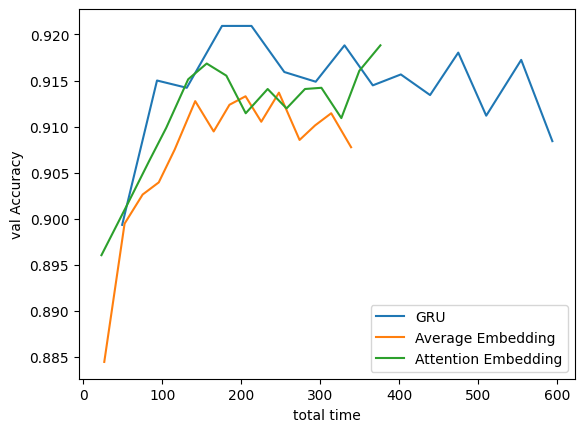

In [30]:
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")

##Positional embeddings

Now let’s define a new PyTorch Module
that applies this positional encoding for us.

In [34]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
    super(PositionalEncoding, self).__init__()

    self.dropout = nn.Dropout(p=dropout)
    self.d_model = d_model

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    # Done so that when we call .to(device), this array will move to it
    self.register_buffer("pe", pe)
    self.batch_first = batch_first

  def forward(self, x):
    if self.batch_first:
      # this code works on (T, B, D) data, so we need to reorder if the input is (B, T, D).
      x = x.permute(1, 0, 2)
    # mixes the input and positional information
    x = x * np.sqrt(self.d_model) + self.pe[: x.size(0), :]
    # Regularizes to avoid overfitting
    x = self.dropout(x)

    # now go back to (B, T, D) shape
    if self.batch_first:
      x = x.permute(1, 0, 2)

    return x

With our new positional encoding, we can redefine the simple averaging approach from
before by inserting our `PositionalEncoding` class directly after the `nn.Embedding` layer.

It does not impact the tensor’s shape in any way, so everything else can remain the same.

In [35]:
simple_positional_embedding = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D) 
  PositionalEncoding(embed_dim, batch_first=True),                     

  # now we will pretend that D is the number of channels in this new interpreation of the data!
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  # let's reduce to a fixed length!
  nn.AdaptiveAvgPool2d((1, None)), # (B, T, D) -> (B, 1, D)

  nn.Flatten(),            # (B, 1, D) -> (B, D)

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
simple_positional_embedding_results = train_network(simple_positional_embedding, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

Let's define the
positional encoding followed by three rounds of hidden layers.

In [37]:
embedding_layers = nn.Sequential(
  *(
      [PositionalEncoding(embed_dim, batch_first=True)] + 
      [nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.LeakyReLU()) for _ in range(3)]
  )
)

Now, we can define an attention-based network with positional encoding.

In [38]:
attention_positional_embedding = nn.Sequential(
  AttentionEmbedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx, embedding_layers=embedding_layers), # (B, T) -> (B, D)
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
attention_positional_embedding_results = train_network(attention_positional_embedding, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='total time', ylabel='val Accuracy'>

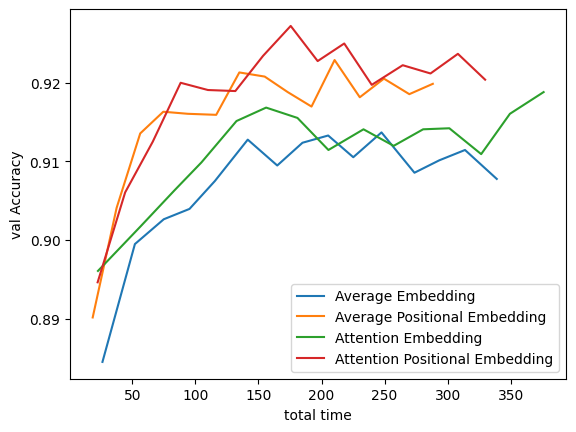

In [40]:
sns.lineplot(x="total time", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=simple_positional_embedding_results, label="Average Positional Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_positional_embedding_results, label="Attention Positional Embedding")

<Axes: xlabel='total time', ylabel='val Accuracy'>

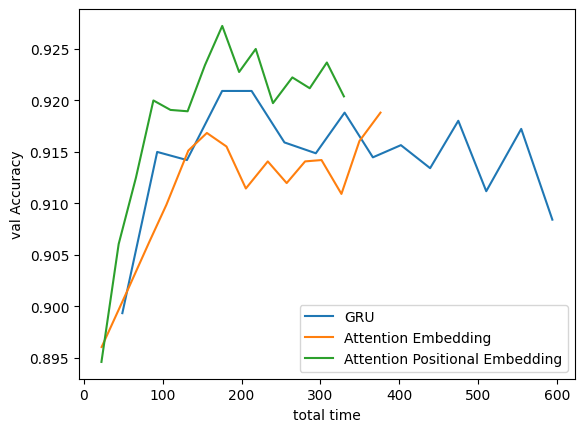

In [41]:
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_positional_embedding_results, label="Attention Positional Embedding")

The takeaway is that positional encodings are a cheap, fast, and effective way to encode
sequence information into our networks. 

Surprisingly, positional encodings were not
invented on their own but rather in conjunction with `Transformers`.

So in most current deep learning, you won’t see a positional
encoding used outside of transformers, but I have found them widely useful beyond
transformers as a fast and easy way to endow a model with the concept of time/ordered
data.

##Transformer

There are two kinds of transformer blocks: an encoder and a decoder.

The encoder block can be used in a network for almost any sequence-based architecture
(e.g., sentiment classification); it does not need to be paired with a decoder.

The decoder block is almost always used with an encoder block and generally used for
sequence tasks with multiple outputs (e.g., machine translation).

Transformers get all of their sequence information from positional
encodings! This is why we needed to learn about positional encodings first, so we can
reuse them to create a transformer model.

Let's implements a simple approach to classifying the sequence
with a transformer. It starts with an `Embedding` layer followed by a `PositionalEncoding`
and then three `TransformerEncoder` layers. 

Ideally, we would use six layers here; but
transformers are even more expensive than RNNs, so we have to handicap the model
to make this example run quickly.

In [43]:
class SimpleTransformerClassifier(nn.Module):

  def __init__(self, vocab_size, D, padding_idx=None):
    super(SimpleTransformerClassifier, self).__init__()

    self.padding_idx = padding_idx 
    self.embedding_layer = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
    self.position_embedding_layer = PositionalEncoding(D, batch_first=True)

    # the main work for our transformer implementation!
    self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=D, nhead=8), num_layers=3)
    self.attention = AttentionAvg(AdditiveAttentionScore(D))
    self.classifier = nn.Sequential(
      nn.Flatten(), # (B, 1, D) -> (B, D)
      nn.Linear(D, D),
      nn.LeakyReLU(),
      nn.BatchNorm1d(D),
      nn.Linear(D, NUM_CLASS)
    )

  def forward(self, inputs):
    if self.padding_idx is not None:
      mask = inputs != self.padding_idx 
    else:
      mask = inputs == inputs  # All entries are `True`

    x = self.embedding_layer(inputs)     # (B, T, D)
    x = self.position_embedding_layer(x) # (B, T, D)

    # Because the resut of our code is (B, T, D), but transformers take input as (T, B, D), 
    # we will have to permute the order of the dimensions before and after
    x = self.transformer(x.permute(1, 0, 2))  # (T, B, D)
    x = x.permute(1, 0, 2)                    # (B, T, D)

    # average over time
    context = x.sum(dim=1) / mask.sum(dim=1).unsqueeze(1)

    return self.classifier(self.attention(x, context, mask=mask))

In [44]:
# Build and train this model!
simple_transformer = SimpleTransformerClassifier(VOCAB_SIZE, embed_dim, padding_idx=padding_idx)

In [ ]:
transformer_results = train_network(simple_transformer, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

Transformers hit the highest accuracy
of all of them and are still improving as we keep training. If we did more epochs and
used more layers, they would probably improve even more! 

But that increases training
time, and the transformer is already slower than the GRU model:

<Axes: xlabel='total time', ylabel='val Accuracy'>

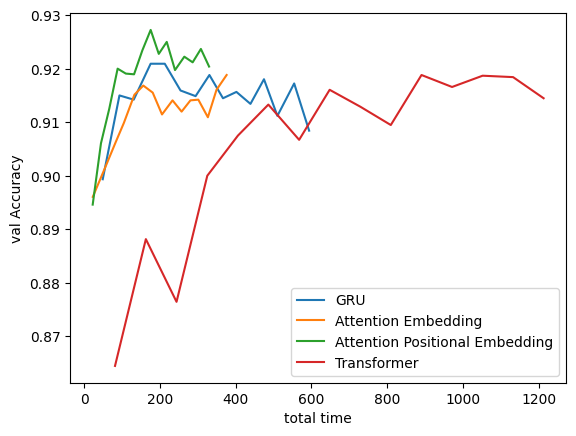

In [46]:
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=attention_embedding_results, label="Attention Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=attention_positional_embedding_results, label="Attention Positional Embedding")
sns.lineplot(x="total time", y="val Accuracy", data=transformer_results, label="Transformer")

By default, the attention-based embedding
with positional encodings is a great tool. It doesn’t always outperform a modern RNN
like the GRU or a LSTM, but it’s a good candidate that is faster to run.

Transformers are a tool that you bring out when you need the maximum possible
accuracy and you’ve got oodles of GPUs available (and data) to pay their hefty price.

That said, transformers can be more accurate and faster when you are working
on massive datasets that require using multiple GPUs.

This is because transformers process all `T` items in a sequence simultaneously, whereas
RNNs need to process them one at a time. 

Doing work this way makes transformers scale
to multiple GPUs better because there is more work to split up and run simultaneously.

With an RNN, you can’t break up the work because one step depends on the previous
step, so you have to wait.